In [11]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm import tqdm
import cv2
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [13]:
model = load_model('../predict_models/DA4649_defect.h5')

In [14]:
def load_img(dir, img_name):
    img = cv2.imread(f'{dir}/{img_name}')
    img_resize = cv2.resize(img, dsize=(400, 400))
    img_hsv = cv2.cvtColor(img_resize, cv2.COLOR_BGR2HSV)
    img_hsv = np.asarray(img_hsv, dtype = np.float32)
    img_scaled = img_hsv.copy()
    img_scaled[:, :, 0] = img_hsv[:, :, 0] / 180.
    img_scaled[:, :, 1] = img_hsv[:, :, 1] / 255.
    img_scaled[:, :, 2] = img_hsv[:, :, 2] / 255.
    return img_scaled

def create_gen(lens_class, y_value):
    # # train 이미지 배열 및 target값 만들기
    img_test_gen = [load_img(f'./model_images/sample_img/{lens_class}', i)
                    for i in tqdm(os.listdir(f'./model_images/sample_img/{lens_class}'))]
    test_y_arr = np.full(len(os.listdir(f'./model_images/sample_img/{lens_class}')), y_value)

    # test 이미지 배열 및 target값 만들기
    # img_test_gen = [load_img(f'./model_images/DA4649_rotate/test/{lens_class}', i)
    #                 for i in tqdm(os.listdir(f'./model_images/DA4649_rotate/test/{lens_class}'))]
    # test_y_arr = np.full(len(os.listdir(f'./model_images/DA4649_rotate/test/{lens_class}')), y_value)
    return img_test_gen, test_y_arr

train_normal, train_normal_y= create_gen('normal', 0)
train_center, train_center_y= create_gen('center', 1)
train_colorpoor, train_colorpoor_y= create_gen('colorpoor', 2)
train_dotmissing, train_dotmissing_y = create_gen('dotmissing', 3)
train_inkcut, train_inkcut_y= create_gen('inkcut', 4)
train_line, train_line_y= create_gen('line', 5)

train_X = np.asarray(train_normal + train_center + train_colorpoor + train_dotmissing + train_inkcut + train_line)

train_Y = to_categorical(np.concatenate((train_normal_y, train_center_y, train_colorpoor_y, train_dotmissing_y, train_inkcut_y, train_line_y), axis=0),6)

0it [00:00, ?it/s]
100%|██████████| 52/52 [00:01<00:00, 35.82it/s]


In [15]:
Y_pred = model.predict(train_X)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(train_Y, axis = 1)

[[52  0  0  0  0]
 [ 0 50  0  0  0]
 [ 0  0 52  0  0]
 [ 0  0  0 52  0]
 [ 8  0 13 23  8]]


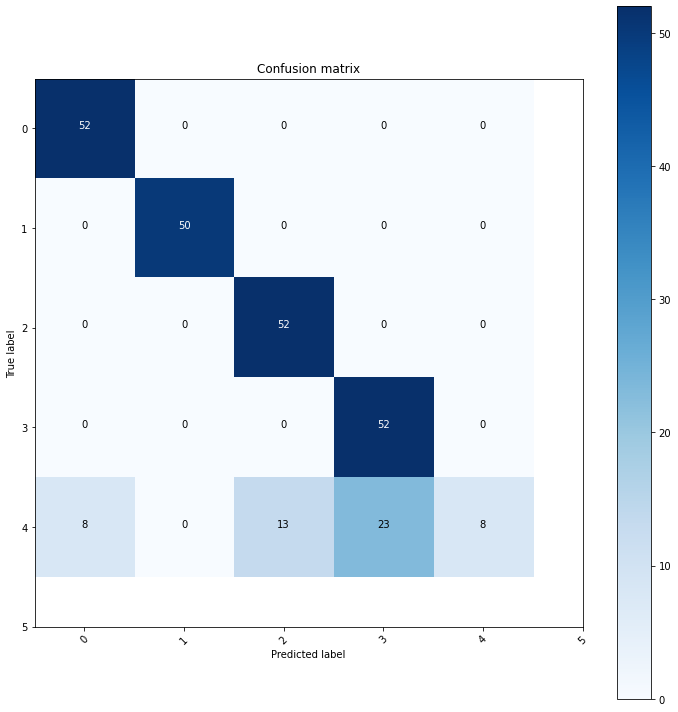

In [16]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(6))